### 1. Decompress input data

In [374]:
%%bash
unzip catdog_data.zip > /dev/null 2>&1

### 2. Examine input images

In [375]:
%%bash
ls catdog_data/

test
train
validation


In [376]:
%%bash
ls catdog_data/train/*/*|wc -l
ls catdog_data/train/cats/*|wc -l
ls catdog_data/train/dogs/*|wc -l
ls catdog_data/test/*/*|wc -l
ls catdog_data/validation/*/*|wc -l

    2000
    1000
    1000
     400
     600


In [382]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import *
from keras.layers import *
from statistics import mean
from matplotlib import pyplot
import typing
import cv2

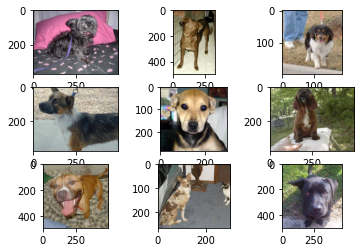

In [383]:
# plot dog photos from the dogs vs cats dataset
# define location of dataset
folder = 'catdog_data/train/dogs/'
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(3, 3, i+1)
    # define filename
    filename = f"{folder}dog.{str(i)}.jpg"
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

### 4. Pre-process and augment input images
Tutorial here: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory

In [384]:
#Specifying the image
Image_Width=360
Image_Height=360
Batch_Size = 32
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [385]:
# randomly rotate the train images
train_generator = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=45, fill_mode='nearest', 
    brightness_range = (0.8, 1.25),
    zoom_range= (0.8, 1.25),
    width_shift_range=0.2, height_shift_range=0.2,
    channel_shift_range=50
)

# non-augmented original image data generators
original_generator = ImageDataGenerator(rescale=1./255)
test_img_flow = original_generator.flow_from_directory(batch_size=Batch_Size, directory="catdog_data/test", target_size=Image_Size, class_mode="binary")
val_img_flow = original_generator.flow_from_directory(batch_size=Batch_Size, directory="catdog_data/validation/", target_size=Image_Size, class_mode="binary")

Found 400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


### 5. Create a 5-layer CNN model

In [399]:
def create_CNN_Model(Image_size: tuple, Image_channels=3) -> keras.models.Sequential:
    assert len(Image_Size)==2 and Image_Size[0]>0 and Image_Size[1]>0, "Image_size must be a tuple of two positive integers!"
    model=Sequential()
    model.add(Conv2D(32,(3,3),activation='relu', kernel_initializer=keras.initializers.he_uniform(seed=42), input_shape=(Image_Width,Image_Height,Image_Channels)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64,(3,3), kernel_initializer=keras.initializers.he_uniform(seed=42), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128,(3,3), kernel_initializer=keras.initializers.he_uniform(seed=42), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(256,(3,3), kernel_initializer=keras.initializers.he_uniform(seed=42), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512,activation='relu', kernel_regularizer=keras.regularizers.L2(5e-3)))
    model.add(Dense(1,activation='sigmoid'))
    return model

model = create_CNN_Model(Image_size=Image_Size)
model.summary()

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_318 (Conv2D)         (None, 358, 358, 32)      896       
                                                                 
 batch_normalization_205 (Ba  (None, 358, 358, 32)     128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_306 (MaxPooli  (None, 179, 179, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_319 (Conv2D)         (None, 177, 177, 64)      18496     
                                                                 
 batch_normalization_206 (Ba  (None, 177, 177, 64)     256       
 tchNormalization)                                               
                                                     

In [394]:
from keras.optimizers import Adam, SGD, RMSprop

In [401]:
def fitted_model(model: Sequential, lr: float, train_imgs: keras.preprocessing.image.DirectoryIterator, val_imgs: keras.preprocessing.image.DirectoryIterator) -> typing.Tuple:
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=["accuracy"])
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='weights.best.inc.blond.hdf5', verbose=1, save_best_only=True)
    model_history = model.fit(train_imgs, validation_data=val_imgs, steps_per_epoch=len(train_imgs), validation_steps=len(val_imgs), epochs=10, callbacks=[checkpointer])
    return (model, model_history)

### 5. Train the augmented dataset, thus saving, loading the model and test the accuracy using the test data set (100 epochs for four augmented datasets each, finally with the original training dataset for 100 epochs)

In [402]:
training_history: typing.Dict[str, typing.List[float]] = {}
for his_key in ('loss', 'accuracy', 'val_loss', 'val_accuracy'):
    training_history[his_key] = [] 

acc_per_100_epochs: typing.List[float] = []

# first 50% epochs: 2e-3, 50%-80% epochs: 5e-4, 80%-100% epochs: 1e-4
def obtain_lr(initial_lr: float, total_epochs: int, round_index: int, epochs_per_round: int) -> float:
    assert total_epochs>=10 and total_epochs%10==0, "The number of datasets must be divsible by 10!"
    assert 0<(round_index*epochs_per_round)<=total_epochs, "The index of an epoch 'i' must suffice 0<i<=total_epochs!"
    return initial_lr if round_index*epochs_per_round<=total_epochs/2 else initial_lr/4 if round_index*epochs_per_round<=total_epochs*0.8 else initial_lr/20

# 100 epochs for each augmented dataset, maximally 500 epochs, stop training when the average validation accuracy of last 10 epochs becomes above 0.9
stop_training: bool = False
rounds_per_dataset: int = 10
for dataset_count in range(1, 6):
    if stop_training: break
    train_img_flow = train_generator.flow_from_directory(batch_size=Batch_Size, directory="catdog_data/train", target_size=Image_Size, class_mode="binary")
    for round_count in range(1, rounds_per_dataset+1):
        lr = obtain_lr(2e-3, 100, round_count, 10)
        print(f'Learning rate for this round is: {str(lr)}')
        model, history = fitted_model(model, lr, train_img_flow, val_img_flow)
        for his_key in history.history.keys():
            training_history[his_key].extend(history.history[his_key])
        sliding_avg_10_acc: float = mean(training_history['val_accuracy'][-10:])
        if sliding_avg_10_acc > 0.9: 
            stop_training = True   
            break
    acc = model.evaluate(test_img_flow, verbose=0)[1]
    print(f"Updated accuracy after using {str(dataset_count)} augmented training datasets: {round(acc, 4)*100}")
    model.save("dog_cat_adam_aug_CNN.h5")

Found 2000 images belonging to 2 classes.
Learning rate for this round is: 0.002
Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 31.9966 - accuracy: 0.5350
Epoch 1: val_loss improved from inf to 21.23908, saving model to weights.best.inc.blond.hdf5
63/63 [==============================] - 66s 901ms/step - loss: 31.9966 - accuracy: 0.5350 - val_loss: 21.2391 - val_accuracy: 0.4850
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 13.9103 - accuracy: 0.5600
Epoch 2: val_loss improved from 21.23908 to 8.66852, saving model to weights.best.inc.blond.hdf5
63/63 [==============================] - 43s 683ms/step - loss: 13.9103 - accuracy: 0.5600 - val_loss: 8.6685 - val_accuracy: 0.5150
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 6.0928 - accuracy: 0.5610
Epoch 3: val_loss improved from 8.66852 to 4.43533, saving model to weights.best.inc.blond.hdf5
63/63 [==============================] - 42s 667ms/step - loss: 6.0928 - accuracy:

In [ ]:
%%bash
# grep validation accuracy using Perl-style regex
# MacOS-specific
grep val_accuracy Project1.1.ipynb|gsed -r 's/\\n",$//'|ggrep -Po "(?<=val_accuracy:\s).+"
# Linux-specific version:
#grep val_accuracy Project1.1.ipynb|sed -r 's/\\n",$//'|grep -Po "(?<=val_accuracy:\s).+"

### 6. Export the training and validation history into a json file via <code>json.dumps</code>

In [404]:
from json import dumps # takes a n object and returns to a string

with open("CNN_training_history.json", "w") as f:
    f.write(dumps(training_history))

### 7. Evaluate the accuracy of the trained model after 80 randomly shuffled epochs (5*2 epochs for each augmented data flow)

In [405]:
from keras.models import load_model

model = load_model("dog_cat_adam_aug_CNN.h5")
acc = model.evaluate(test_img_flow, verbose=0)[1]
print(round(acc, 4)*100)

92.25


### 8. Generate plots of training/validation loss and training/validation accuracy

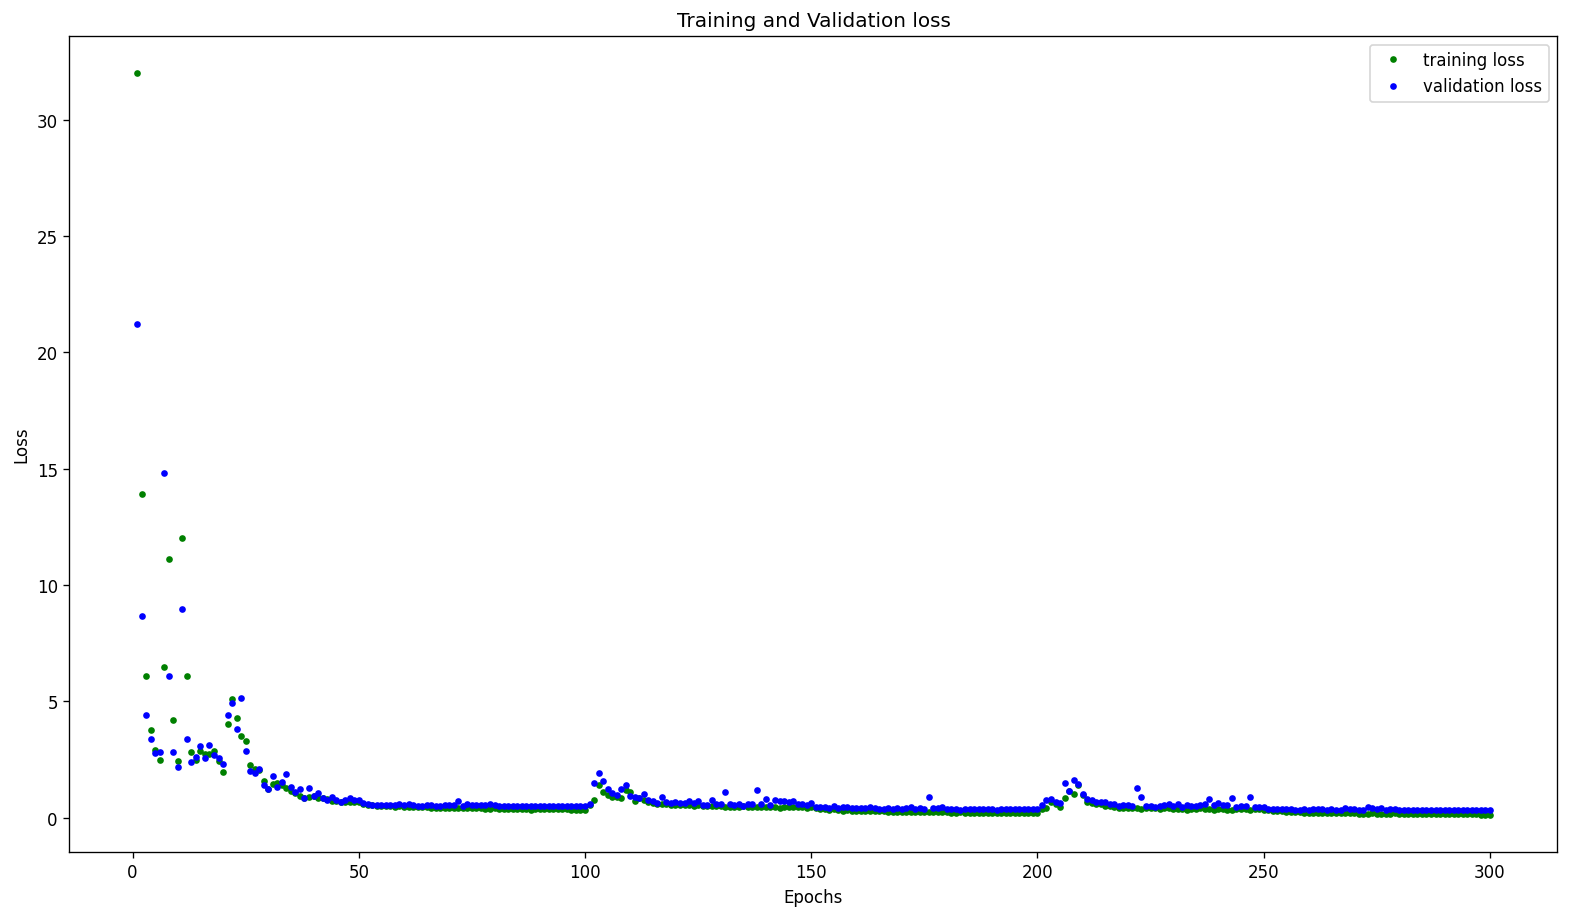

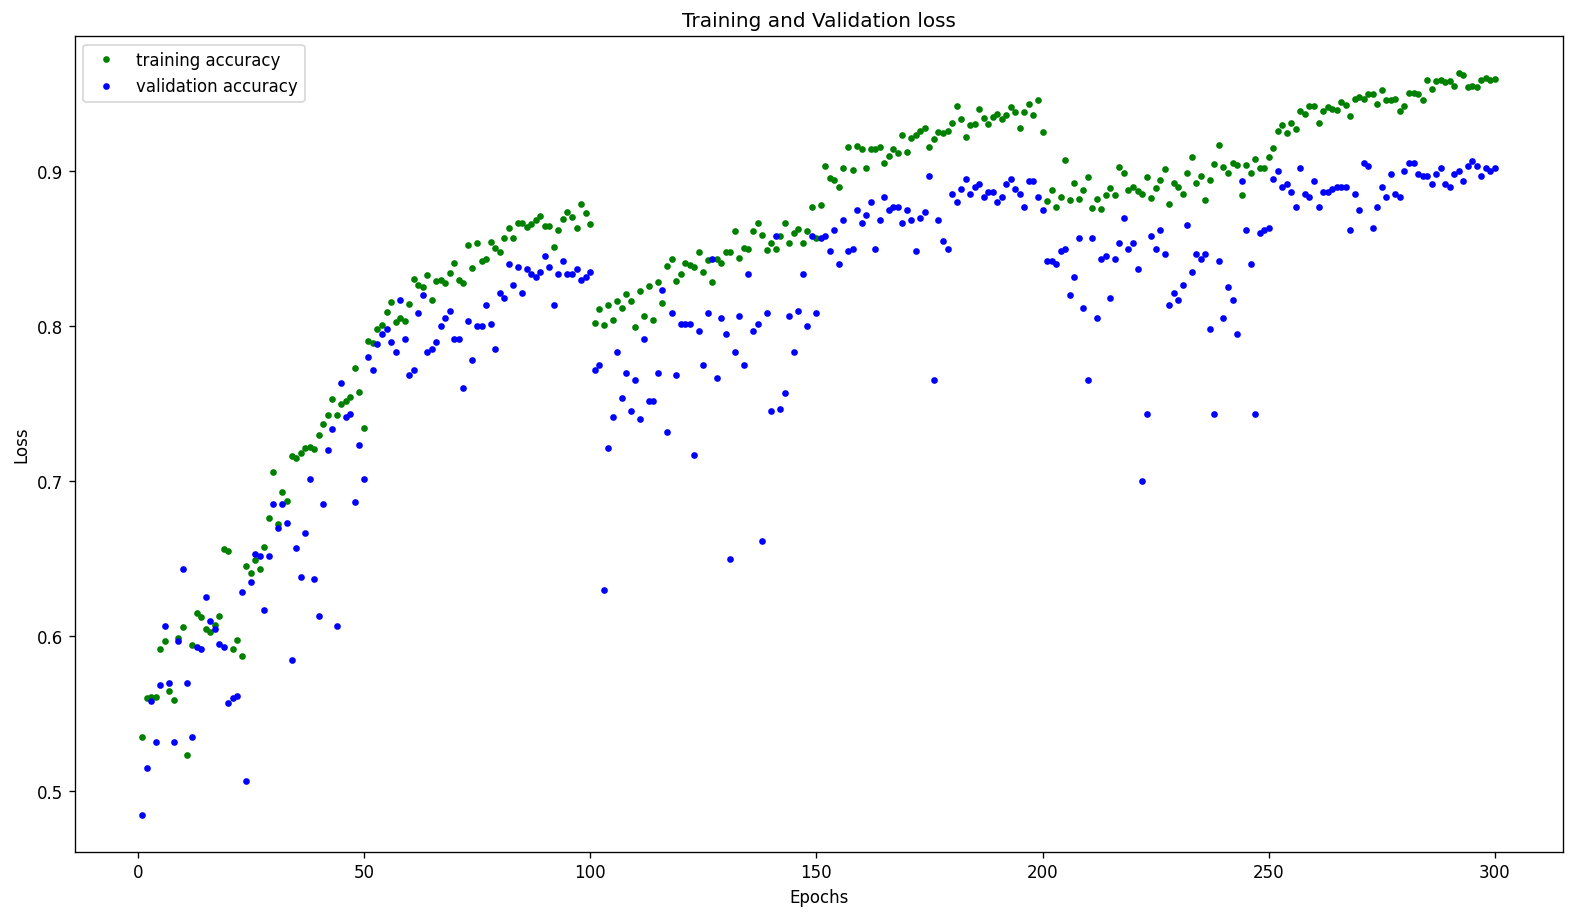

In [51]:
from json import loads
from matplotlib import pyplot as plt
import typing

class NN_training_history_plotter():

    def __init__(self, jsonPath: str):
        self.jsonPath = jsonPath
        self.load_training_history()

    def load_training_history(self):
        with open(self.jsonPath, 'r') as f:
            saved_training_record = loads(f.readline().strip())
        t_loss: typing.List[float] = saved_training_record['loss']
        v_loss: typing.List[float] = saved_training_record['val_loss']
        t_acc: typing.List[float] = saved_training_record['accuracy']
        v_acc: typing.List[float] = saved_training_record['val_accuracy']
        assert len(t_loss)>=10 and len(t_loss)==len(v_loss)==len(t_acc)==len(v_acc), "There shall be at least ten training epochs and the lists that store training loss, validation loss, training accuracy, and validation accuracy must all have the same length!"
        self.t_loss, self.v_loss, self.t_acc, self.v_acc = t_loss, v_loss, t_acc, v_acc

    # Plot losses
    def save_loss_fig(self, saving_path: str):
        epochs = range(1, len(self.t_loss)+1)
        plt.figure(figsize=(16, 9), dpi=120)
        plt.rcParams['savefig.facecolor']='white'
        plt.plot(epochs, self.t_loss, 'g.', label='training loss')
        plt.plot(epochs, self.v_loss, 'b.', label='validation loss')
        plt.title('Training and Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(saving_path)
        plt.show()

    # Plot accuracies
    def save_acc_fig(self, saving_path: str):
        epochs = range(1, len(self.t_loss)+1)
        plt.figure(figsize=(16, 9), dpi=120)
        plt.rcParams['savefig.facecolor'] = 'white'
        plt.plot(epochs, self.t_acc, 'g.', label='training accuracy')
        plt.plot(epochs, self.v_acc, 'b.', label='validation accuracy')
        plt.title('Training and Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(saving_path)
        plt.show()

cnn_plotter = NN_training_history_plotter('CNN_training_history.json')
cnn_plotter.save_loss_fig('./CNN_300epochs_loss.png')
cnn_plotter.save_acc_fig('./CNN_300epochs_acc.png')

In [29]:
t_loss[0]

[31.99662208557129,
 13.910279273986816,
 6.092752933502197,
 3.7595534324645996,
 2.9137635231018066,
 2.485135316848755,
 6.465958118438721,
 11.11806869506836,
 4.185820579528809,
 2.443279266357422,
 12.02586841583252,
 6.091480255126953,
 2.8109257221221924,
 2.4850611686706543,
 2.890392303466797,
 2.754225730895996,
 2.7478041648864746,
 2.8611960411071777,
 2.427947521209717,
 1.9550379514694214,
 4.036523818969727,
 5.1030354499816895,
 4.287998199462891,
 3.5151586532592773,
 3.279153347015381,
 2.2795681953430176,
 2.1075692176818848,
 2.0462069511413574,
 1.6007461547851562,
 1.2210103273391724,
 1.465785026550293,
 1.4851971864700317,
 1.415112853050232,
 1.2806137800216675,
 1.1595675945281982,
 1.0522829294204712,
 0.9378465414047241,
 0.8556607961654663,
 0.874999463558197,
 0.9226441383361816,
 0.8366675972938538,
 0.8469241261482239,
 0.7885131239891052,
 0.7030310034751892,
 0.7142432928085327,
 0.6983449459075928,
 0.6757019758224487,
 0.6768351197242737,
 0.6737957